## Семинар 3 "Определение ключевых точек лица"

ФИО: Бабаков Вадим Валерьевич

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


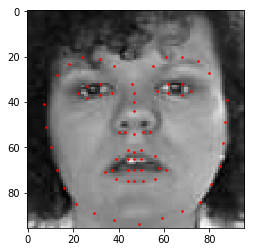

In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, ReLU, ELU
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [5]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=transforms.Compose([
                                               Rescale(68),
                                               RandomCrop(60),
                                               ToTensor()
                                           ]))

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=transforms.Compose([
                                               Rescale(68),
                                               RandomCrop(60),
                                               ToTensor()
                                           ]))

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

In [7]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try: 
        for epoch in range(1, epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

Epoch 24... (Train/Test) MSE: 5.760/6.64727

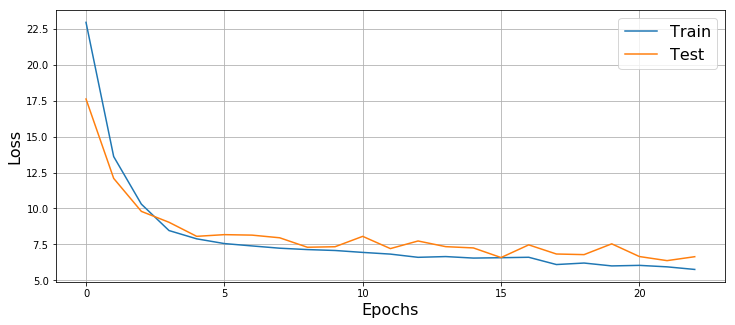

In [8]:
network_elu_1 = Sequential(Linear(1 * 60 * 60, 200), 
                           ELU(),
                           Linear(200, 2 * 68))
train(network_elu_1, 25, 0.01)

Epoch 24... (Train/Test) MSE: 13.788/14.841

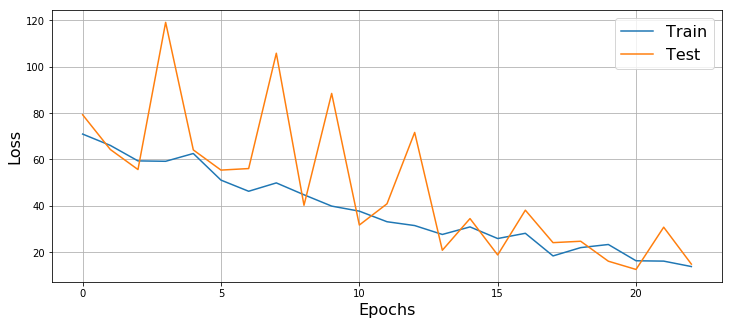

In [9]:
network_relu_1 = Sequential(Linear(1 * 60 * 60, 200), 
                            ReLU(),
                            Linear(200, 2 * 68))
train(network_relu_1, 25, 0.01)

Epoch 24... (Train/Test) MSE: 14.275/15.037

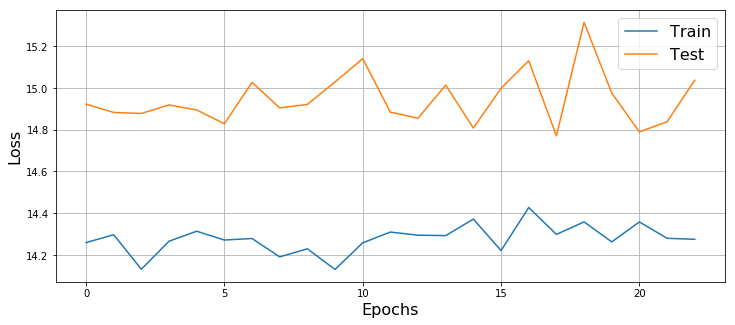

In [10]:
network_sig_1 = Sequential(Linear(1 * 60 * 60, 200), 
                           Sigmoid(),
                           Linear(200, 2 * 68))
train(network_sig_1, 25, 0.01)

Epoch 24... (Train/Test) MSE: 6.267/6.3503

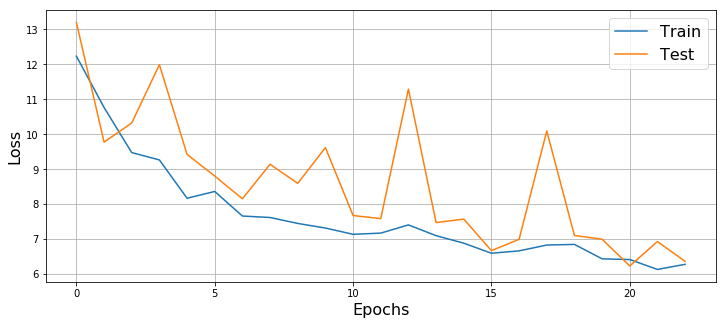

In [11]:
network_elu_2 = Sequential(Linear(1 * 60 * 60, 200), 
                           ELU(),
                           Linear(200, 200),
                           ELU(),
                           Linear(200, 2 * 68))
train(network_elu_2, 25, 0.01)

Epoch 24... (Train/Test) MSE: 14.159/15.143

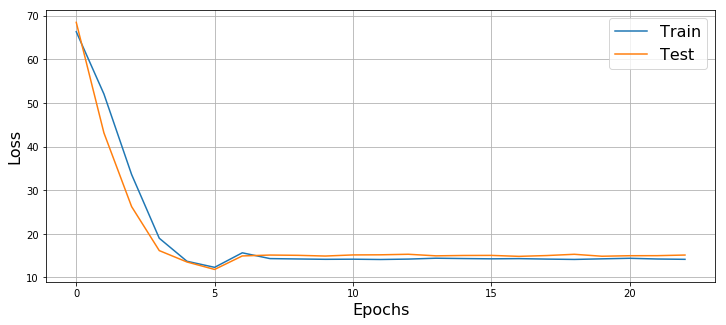

In [12]:
network_relu_2 = Sequential(Linear(1 * 60 * 60, 200), 
                            ReLU(),
                            Linear(200, 200),
                            ReLU(),
                            Linear(200, 2 * 68))
train(network_relu_2, 25, 0.01)

Epoch 24... (Train/Test) MSE: 14.488/14.964

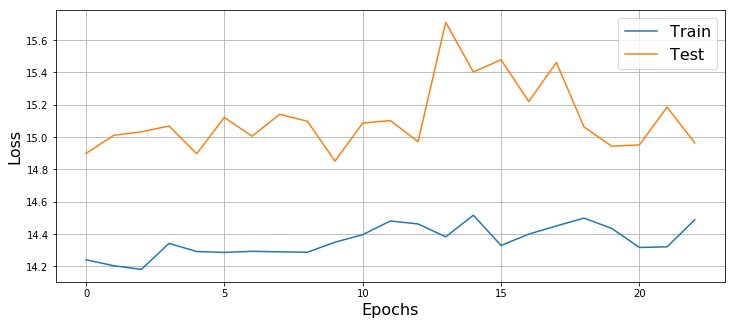

In [13]:
network_sig_2 = Sequential(Linear(1 * 60 * 60, 200), 
                           Sigmoid(),
                           Linear(200, 200),
                           Sigmoid(),
                           Linear(200, 2 * 68))
train(network_sig_2, 25, 0.01)

In [14]:
network0 = Sequential(Linear(1 * 60 * 60, 400), 
                      ReLU(),
                      Linear(400, 400), 
                      ReLU(),
                      Linear(400, 2 * 68))

In [15]:
# train(network0, 30, 0.01)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=4)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 60 * 60).type(dtype))
y_pred = network_elu_1(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

(2, 60, 60)


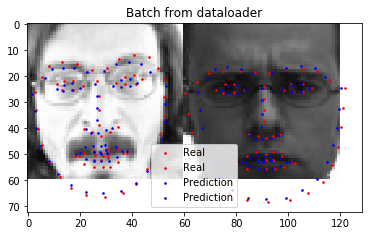

In [24]:
# Визуальный пример предсказания однослойной сети с функцией активации ELU

Таким образом, лучшие результаты показала функция ELU в однослойной сети.

Минимальный Loss, достигнутый на тестовой выборке, составил 6.64727